In [1]:
snr=10e3
samples=1000
mod_size=2
quant_size=0.05
hist_bins_max = 100

plot=True
debug=False

In [2]:
import pandas as pd
import numpy as np
# pd.set_option("display.max_rows",1000)
pd.set_option("display.max_columns",1000)
pd.set_option('expand_frame_repr',False)
pd.set_option('display.max_colwidth',1000)
import plotly as py
import cufflinks
py.offline.init_notebook_mode(connected=True)
import pylab as plt

In [3]:
# print(__file__)
import os, sys
root_path=os.path.abspath('').replace('\\','/').rsplit('int_force',1)[0]
sys.path.append(root_path)
import int_force
plt.rc('figure', facecolor='w')
fig_size_inch=11
plt.rc('figure', figsize=(fig_size_inch,fig_size_inch))

In [4]:
# random cov and generate data
if 1:
    cov=int_force.rand_data.rand_data.rand_cov(snr=snr)
    print(cov)
else:
    cov=np.mat([[ 0.67828027, -0.14103396], [-0.14103396,  0.02942934]])
    
cov_angle=int_force.rand_data.find_slop.get_cov_ev(cov)[1]
data = int_force.rand_data.rand_data.random_data(cov, samples)

# modulo and quantization
tmp = int_force.methods.methods.sign_mod(data, mod_size)
tmp = int_force.methods.methods.to_codebook(tmp, quant_size, 0)
tmp = int_force.methods.methods.from_codebook(tmp, quant_size, 0)

tmp.columns = [['after'] * 2, tmp.columns.values]
data.columns = [['before'] * 2, data.columns.values]
data = data.join(tmp)
del tmp

[[ 3.52758503 -0.94426594]
 [-0.94426594  0.2528688 ]]


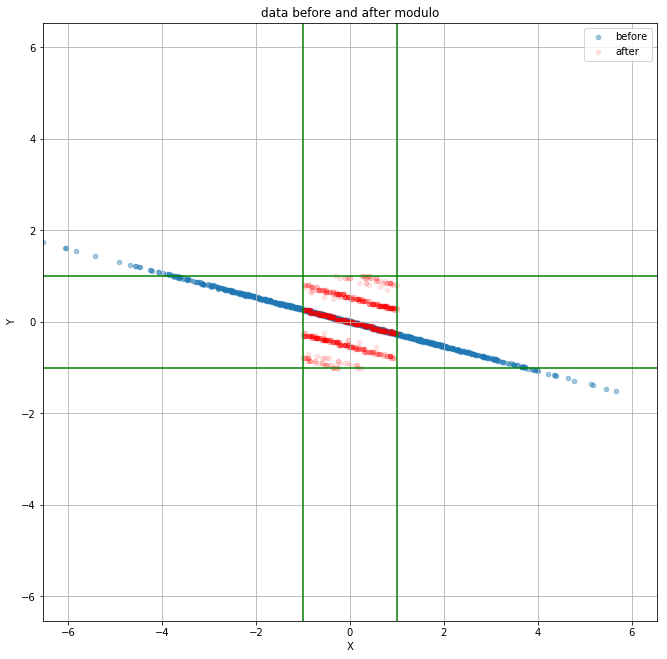

In [5]:
if 1:
    max_num=data[['after','before']].abs().values.max()
    ax=data.before.plot.scatter(x='X', y='Y', label='before', alpha=0.4, title='data before and after modulo')
    data.after.plot.scatter(x='X', y='Y', label='after', 
                            ax=ax, c='red', alpha=0.1, grid=True, xlim=[-max_num,max_num],ylim=[-max_num,max_num])
    for l in [-mod_size/2, mod_size/2]:
        plt.axvline(l, color='g') 
        plt.axhline(l, color='g')     
else:
    before_after=data[['after','before']].stack(0).reset_index(1,drop=False).rename(columns=dict(level_1='state'))
    fig=before_after.figure(
        kind='scatter', x='X', y='Y', categories='state', size=4, opacity=0.6)
    py.offline.iplot(fig)

closing picture


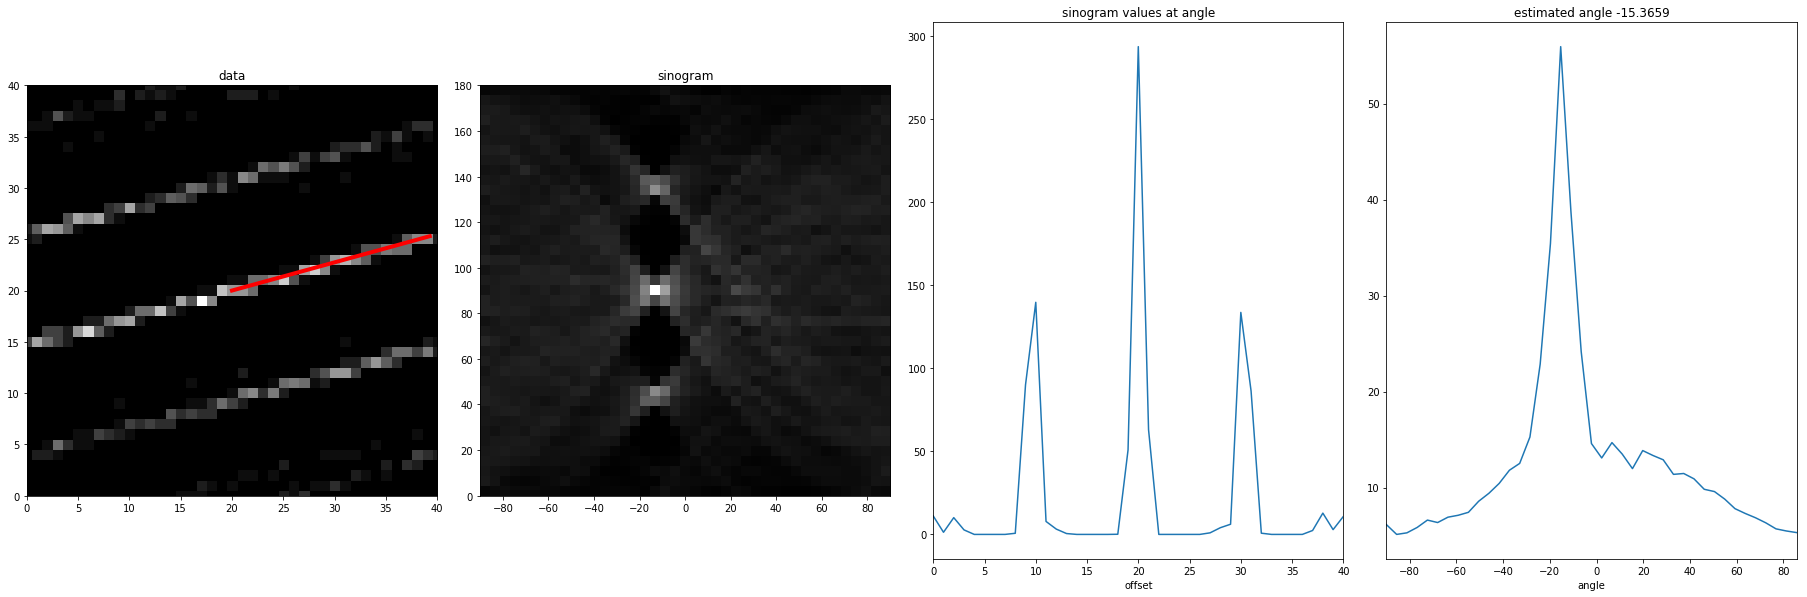

In [6]:
# doing sinogram
sinogram_dict = int_force.methods.sinogram.calc_sinogram(data.after.X.values, data.after.Y.values, hist_bins_max=hist_bins_max, plot=plot, quant_size=quant_size)

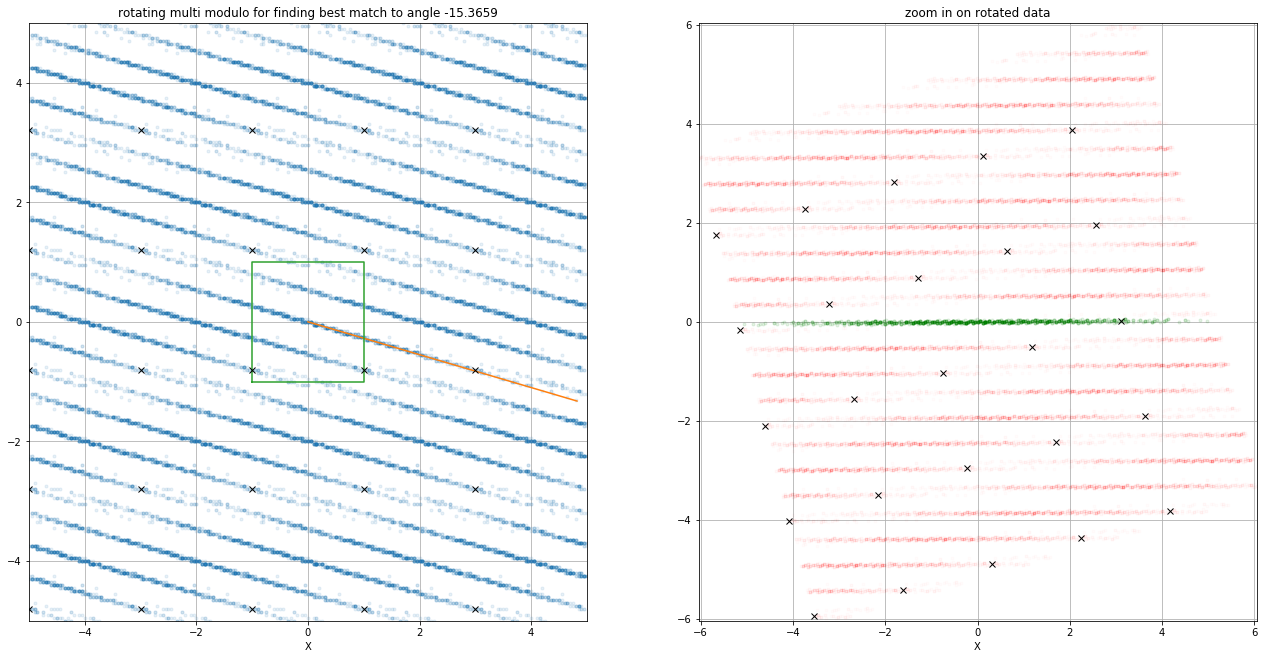

In [7]:
# rotating by sinogram angle
tmp = int_force.methods.sinogram.find_closest(number_of_shift_per_direction=2, data_after=data.after, mod_size=mod_size, angle_by_std=sinogram_dict['angle_by_std'],plot=plot)

In [8]:
data = pd.merge(tmp, data, left_on=[('remove', 'x_at_mod'), ('remove', 'y_at_mod')], right_on=[('after', 'X'), ('after', 'Y')], how='right').T.sort_index().T.drop('remove', axis=1)
del tmp
error=data.recovered - data.before
error.columns = [['error']*2, error.columns.values]
data = data.join(error)
del error
mse = data.error.pow(2).values.mean()
rmse=mse ** 0.5
print('rmse: %f'%rmse)
data.head()

rmse: 0.553253


after          before           distances_angle major_distance minor_distance modulo_center_x modulo_center_y recovered            stat x_after_rotation y_after_rotation     error          
      X     Y         X         Y distances_angle major_distance minor_distance modulo_center_x modulo_center_y         X     Y  distance x_after_rotation y_after_rotation         X         Y
0  -1.0 -0.80  3.017993 -0.806034        0.434436       0.023542       3.104746             4.0             0.0       3.0 -0.80  0.085637         3.104746         0.023542 -0.017993  0.006034
1  -1.0 -0.80  3.019266 -0.788200        0.434436       0.023542       3.104746             4.0             0.0       3.0 -0.80  0.085637         3.104746         0.023542 -0.019266 -0.011800
2  -1.0 -0.30  1.017016 -0.281197        1.333391       0.024295       1.043748             2.0             0.0       1.0 -0.30  0.045170         1.043748        -0.024295 -0.017016 -0.018803
3  -1.0 -0.30  1.002972 -0.278431        1.333391       0.024295       1.043748             2.0             0.0       1.0 -0.30  0.045170         1.043748        -0.024295 -0.002972 -0.021569
4  -1.0 -0.25  1.023118 -0.263168        1.329610       0.023918       1.030499             2.0             0.0       1.0 -0.25  0.044528         1.030499         0.023918 -0.023118  0.013168